<h1>Challenge 2: Plankton Image Classification</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>April 2019</i>

We decided to work directly with the images as they are provided. As we had worked with csv-files before we wanted to try a different approach to this problem. Reasoning for different decions are provided at the appropiate places through the notebook. 

## Data Exploration
<hr style="height:1px;border:none;color:#333;background-color:#333;" /> 

### Fetching Data

#### Importing libraries

In [49]:
%matplotlib inline
# For configuration and jupiter
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

import zipfile
from extract_zip import extract_zip_to_memory # function for decompressing zip in memory
from PIL import Image, ImageOps # image handling
from io import BytesIO # image handling

basepath = '/mnt/datasets/plankton/flowcam/'


#### Fetching datasets

In [50]:
# datasets
nativeDF = pd.read_csv(basepath + 'features_native.csv.gz')
skimagDF = pd.read_csv(basepath + 'features_skimage.csv.gz')
labelsDF = pd.read_csv(basepath + 'meta.csv')

#### Exploring the datasets
We do not use the "features_skimage.csv.gz" dataset. "features_native.csv.gz" are used to look at the distribution of height and width of the images. Labels from "meta.csv" is used in training of the Neural Net. 

In [72]:
print("Total amount of pictures in the complete dataset: ", nativeDF.shape[0])
print("Maximum width of a picture: ", nativeDF.width.max())
print("Maximum height of a picture: ", nativeDF.height.max())

Total amount of pictures in the complete dataset:  243610
Maximum width of a picture:  972
Maximum height of a picture:  739


In [74]:
image_filename = basepath + "imgs.zip"
imgFiles = extract_zip_to_memory(image_filename)

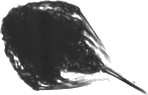

In [77]:
# display a picture
Image.open(imgFiles['imgs/32748610.jpg'])

In [90]:
print(labelsDF.loc[labelsDF["objid"] == 32748610.0].level2.values[0])

nauplii (Crustacea)


Above we can see a specimen of the

Text(0.5,1,'Plot')

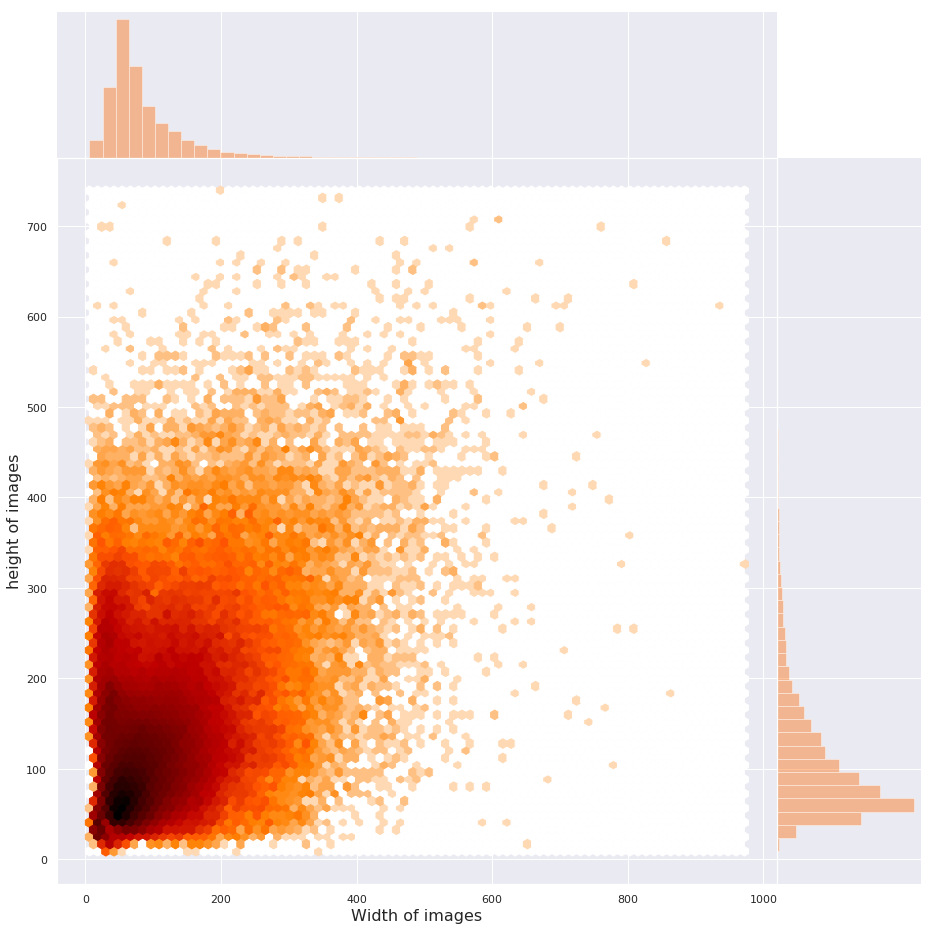

In [62]:
# Joint plot with histogram and binned scatter of the width and height of the images
hexmap = sns.jointplot(nativeDF.width, nativeDF.height, kind='hex', space=0, color=cmap(.3), height=13,
                       cmap=plt.cm.gist_heat_r,  
                       joint_kws=dict(gridsize=80, bins="log"))
hexmap.ax_joint.set_xlabel('Width of images',  fontsize=16)
hexmap.ax_joint.set_ylabel('height of images', fontsize=16)



The above plot shows the distribution of the width and height of all the images in the dataset. We can see the majority of the images are less than 100x100 pixels (the bins used for plotting are normalized), but there are some images which are significantly bigger. The maximum width is 972 pixels and the maximum heigth is 739 pixels. 

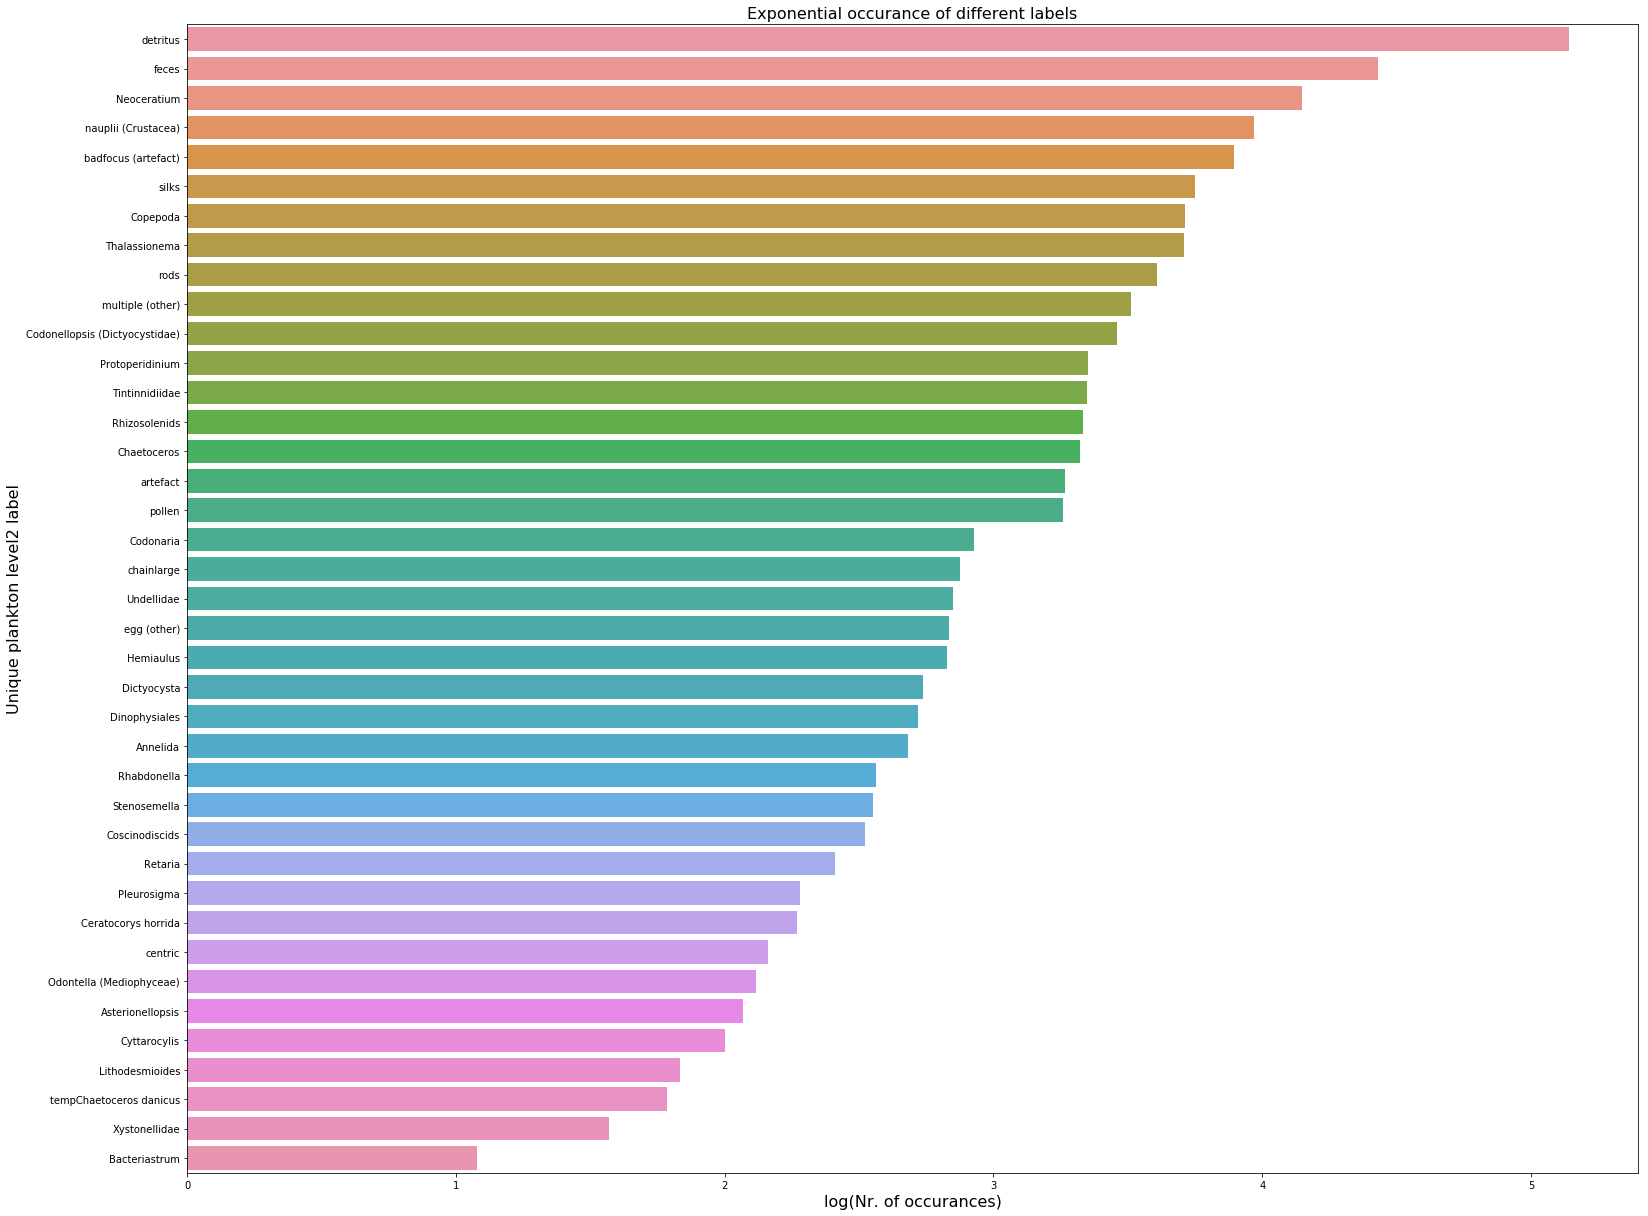

In [35]:
# Barplot
number_unique_names = labelsDF.groupby('level2', as_index=True)['id'].count()
number_unique_names.sort_values(inplace=True, ascending=False)

figure, ax = plt.subplots(figsize=(23,17))
ax = sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values))


plt.ylabel('Unique plankton level2 label', fontsize= 16)
plt.xlabel('log(Nr. of occurances)', fontsize= 16)
plt.title('Exponential occurance of different labels', fontsize=16)
plt.tight_layout()

In [36]:
unique_names = labelsDF.groupby('level2', as_index=False)['id'].count()
unique_names.sort_values(inplace=True, ascending=False, by='id')

print(unique_names.iloc[0])
print(unique_names.iloc[-1])

level2    detritus
id          138439
Name: 30, dtype: object
level2    Bacteriastrum
id                   12
Name: 2, dtype: object


The plot above shows the distribution of the different labels that the different images are assigned to. The x axis is exponential as the most numerous labels would completly dominate the plot otherwise. There is a big disparity in the labels as the least represented label (Bacteriastrum) only have 12 images and the most represented label (Detritus) have 138439 images. This will make classification difficult if it is left unaccounted for. 

## Data Pre-processing
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

The images in the dataset have varied height and width. As we will use a convoluted neural net we need all images to be of the same input size. We solve this by creating a blank 972x972 (max size and square) image. We then scale up the orignal image to the new size while we retain the original ratio between height and width. Next the original is put in the middle of the blank 972x972 which works like padding of the original. Finally we scale the image down to 100x100 as this is the input shape for the CNN.

In [ ]:
# code inspired by https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

def image_processing(path):
    desired_size = 972 # max of width and height in dataset
    im_orginal = Image.open(path)
    old_size = im_orginal.size  # old_size[0] is in (width, height) format
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_scaled = im_orginal.resize(new_size) # scale up picture before padding to keep information
    
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    im_padded = ImageOps.expand(im_scaled, padding, fill=255) # padding of scaled picture
    
    final_size = (100, 100) # input size for CNN
    im_final = im_padded.resize(final_size, resample=0) # resize to input size of CNN
    return np.array(im_final)

Earlier we discovered a disparity in the distribution of the different labels. This will make it more difficult for our Neural Network to predict the correct level 2 taxonomy for Plankton of the less represented labels. We resolve this by generating new images for the less represented labels. We do this by transposing, rotating and flipping the original image. This way we are able to generate more data for our CNN.

In [ ]:
# generate data function

## Model Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

## Parameter Optimisation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

## Model Evaluation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    